In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import plotly.io as pio
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
#import meshparty
#from meshparty import trimesh_vtk, trimesh_io 
import navis
import pygsheets
import plotly.graph_objs as go
import trimesh

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
vol2 =cv('gs://zheng_mouse_hippocampus_production/v2/seg_m195',parallel=True, progress=False, use_https=True)

client = CAVEclient('zheng_ca3')


In [12]:
gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet2 = gc.open('nuclei_table_250217')
worksheet2 = sheet2.worksheet('title','nuclei')
nuc_df = worksheet2.get_as_df(start='A1')
#pcsyn_df[['pre_pt_supervoxel_id','post_pt_supervoxel_id']] = str_columns[['pre_pt_supervoxel_id','post_pt_supervoxel_id']]
#syn_df = pcsyn_df[pcsyn_df['synapse'] == 'Yes']

sheet3 = gc.open('CA3 proofreading')
worksheet3 = sheet3.worksheet('title','11.inhibitory_cells')
inh_df = worksheet3.get_as_df(start='A7')


nuc_df_inh = nuc_df[nuc_df['group']=='inh']
nuc_df_pyc = nuc_df[nuc_df['group']=='pyr']
nuclei_coord_inh = nuc_df_inh[['x','y','z']].to_numpy()
nuclei_coord_pyc = nuc_df_pyc[['x','y','z']].to_numpy()


/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


In [5]:
# requires 6GB memory
filepath = './data/test_assign_output_20240722181157_final_edgelist.df'
syn_table = pd.read_csv(filepath,  dtype={'centroid_x':float,'centroid_y':float,'centroid_z':float,'cleft_segid':str, 'size':int})

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_94951/633254816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_syn_table['centroid_x'] = large_syn_table['centroid_x'].astype(int)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_94951/633254816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_syn_table['centroid_y'] = large_syn_table['centroid_y'].astype(int)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_94951/633254816.py:4: SettingWithCopyWarning: 
A va

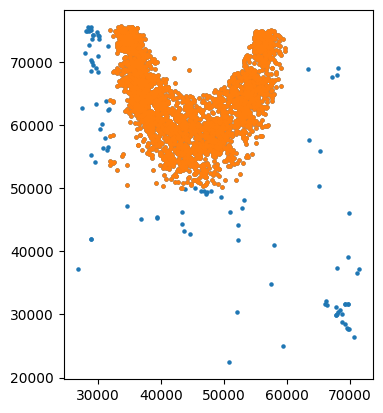

In [6]:
large_syn_table = syn_table[syn_table['size'] > 10000]
large_syn_table['centroid_x'] = large_syn_table['centroid_x'].astype(int)
large_syn_table['centroid_y'] = large_syn_table['centroid_y'].astype(int)
large_syn_table['centroid_z'] = large_syn_table['centroid_z'].astype(int)

plt.scatter(large_syn_table['centroid_x'], large_syn_table['centroid_y'], s=5)
large_syn_df = large_syn_table[(large_syn_table['centroid_y'] > 50000) & (large_syn_table['centroid_x'] < 60000)& (large_syn_table['centroid_x'] > 32000)]
plt.scatter(large_syn_df['centroid_x'], large_syn_df['centroid_y'], s=5)
ax = plt.gca()
ax.set_aspect('equal')

del syn_table # free up memory

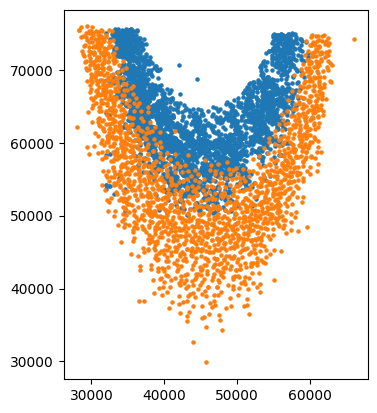

In [7]:

PC_nucleus_file_path = './data/all_pyramidal_cells_v2.csv'
table = pd.read_csv(PC_nucleus_file_path, dtype={'x':int, 'y':int, 'z':int, 'nuclei_id':str})
nuclei_coord = table[['x','y','z']].to_numpy()
syn_coord = large_syn_df[['centroid_x','centroid_y','centroid_z']].to_numpy()

plt.scatter(large_syn_df['centroid_x'], large_syn_df['centroid_y'], s=5)
plt.scatter(table['x'], table['y'], s=5)
ax = plt.gca()
ax.set_aspect('equal')


In [14]:
import trimesh.transformations as tra

def mesh_downsample(m, voxel_size):
    
    # Downsample mesh vertices using a voxel grid and update faces accordingly.
    vertices = m.vertices
    faces = m.faces
    min_coords = vertices.min(axis=0)
    voxel_indices = np.floor((vertices - min_coords) / voxel_size).astype(np.int32)
    
    # Dictionary mapping voxel index (tuple) to list of original vertex indices
    voxel_dict = {}
    for i, voxel in enumerate(voxel_indices):
        key = tuple(voxel)
        if key not in voxel_dict:
            voxel_dict[key] = []
        voxel_dict[key].append(i)
    
    new_vertices_list = []
    mapping = np.empty(vertices.shape[0], dtype=np.int32)
    
    # For each voxel, compute the average vertex coordinate and update mapping.
    for new_idx, (key, indices) in enumerate(voxel_dict.items()):
        avg_vertex = vertices[indices].mean(axis=0)
        new_vertices_list.append(avg_vertex)
        for idx in indices:
            mapping[idx] = new_idx
            
    new_vertices = np.array(new_vertices_list)
    new_faces = mapping[faces]
    valid_face_mask = np.apply_along_axis(lambda f: len(set(f)) == 3, 1, new_faces)
    new_faces = new_faces[valid_face_mask]
    
    mesh = trimesh.Trimesh(vertices = new_vertices, faces=new_faces)
    return mesh


def enlarge_mesh_at_fixed_pos(mesh, scale_factor):
    centroid = mesh.centroid
    T1 = tra.translation_matrix(-centroid)
    S = np.eye(4)
    S[0,0] = scale_factor
    S[1,1] = scale_factor
    S[2,2] = scale_factor
    T2 = tra.translation_matrix(centroid)
    transform = tra.concatenate_matrices(T2, S, T1)
    mesh.apply_transform(transform)
    return mesh

In [ ]:
# one thorny, one athorny, one interneuron

import plotly.graph_objs as go
import trimesh

#grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
#decision_values = svm_clf.decision_function(grid_points)
#boundary_coord = grid_points[np.abs(decision_values) < 0.2]
boundary_coord = grid_points[((decision_values < 0) & (decision_values > -0.3))]

#pyc_id = client.chunkedgraph.suggest_latest_roots([648518346440971223,648518346450344364])
pyc_id1 = client.chunkedgraph.suggest_latest_roots(648518346449428431)
pyc_id2 = client.chunkedgraph.suggest_latest_roots(648518346446492124)
pyc_id3 = client.chunkedgraph.suggest_latest_roots(648518346447553683)
mf_id = client.chunkedgraph.suggest_latest_roots(648518346436441623)

ds_rate=10
mesh = vol.mesh.get(pyc_id1)[pyc_id1]   
mesh.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh = mesh_downsample(mesh, ds_rate)
mesh = enlarge_mesh_at_fixed_pos(mesh, 1.05)

mesh2 = vol.mesh.get(pyc_id2)[pyc_id2]   
mesh2.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh2 = mesh_downsample(mesh2, ds_rate)
mesh2 = enlarge_mesh_at_fixed_pos(mesh2, 1.05)

mesh3 = vol.mesh.get(pyc_id3)[pyc_id3]   
mesh3.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh3 = mesh_downsample(mesh3, ds_rate)
mesh3 = enlarge_mesh_at_fixed_pos(mesh3, 1.05)

mesh4 = vol.mesh.get(mf_id)[mf_id]   
mesh4.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh4 = mesh_downsample(mesh4, 5)
mesh4 = enlarge_mesh_at_fixed_pos(mesh4, 1.05)

In [ ]:
# draw XY projection of cell distribution + select cells

navy = 'rgb(26,50,96)'
green = 'rgb(160,210,140)'
skyblue = 'rgb(100,180,220)'

syn = go.Scatter3d(x=syn_coord[:,1], y=syn_coord[:,0], z=syn_coord[:,2]-2000, mode='markers',
                   marker=dict(size=1, color=green, opacity=0.6), name='syn locations')
nuclei_pyc = go.Scatter3d(x=nuclei_coord_pyc[:,1], y=nuclei_coord_pyc[:,0], z=nuclei_coord_pyc[:,2]-2000, mode='markers',
                      marker=dict(size=2.5, color='rgb(26,50,96)', opacity=0.3), name='nuclei locations')
nuclei_inh = go.Scatter3d(x=nuclei_coord_inh[:,1], y=nuclei_coord_inh[:,0], z=nuclei_coord_inh[:,2]-2000, mode='markers',
                      marker=dict(size=2.5, color='rgb(240,35,35)',opacity=0.3), name='nuclei locations')

#boundary = go.Scatter3d(x=boundary_coord[:,0], y=boundary_coord[:,1], z=boundary_coord[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(60,50,60)',opacity=0.5), name='boundary')

mesh_go = go.Mesh3d(x=mesh.vertices[:,1],y=mesh.vertices[:,0],z=mesh.vertices[:,2],
                    i=mesh.faces[:,1],j=mesh.faces[:,0],k=mesh.faces[:,2],color=navy)
mesh_go2 = go.Mesh3d(x=mesh2.vertices[:,1],y=mesh2.vertices[:,0],z=mesh2.vertices[:,2],
                     i=mesh2.faces[:,1],j=mesh2.faces[:,0],k=mesh2.faces[:,2],color='rgb(160,80,160)')
mesh_go3 = go.Mesh3d(x=mesh3.vertices[:,1],y=mesh3.vertices[:,0],z=mesh3.vertices[:,2],
                     i=mesh3.faces[:,1],j=mesh3.faces[:,0],k=mesh3.faces[:,2],color='rgb(240,30,30)')
mesh_go4 = go.Mesh3d(x=mesh4.vertices[:,1],y=mesh4.vertices[:,0],z=mesh4.vertices[:,2],
                     i=mesh4.faces[:,1],j=mesh4.faces[:,0],k=mesh4.faces[:,2],color='rgb(255,140,0)')

scale_bar = go.Scatter3d(x=[72000,72000], y=[20000,25555], z=[1000,1000], mode="lines+text",
                         line=dict(color="black", width=3))

fig = go.Figure(data=[nuclei_pyc,nuclei_inh,syn,mesh_go,mesh_go2, mesh_go3, mesh_go4, scale_bar])
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50),
                  scene=dict(camera=dict(eye=dict(x=0., y=0., z=3)),
                  xaxis=dict(autorange="reversed"),yaxis=dict(autorange="reversed"),
                  zaxis=dict(range=[-2000, 2400]),aspectmode="data"),showlegend=False)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
#fig.update_scenes(zaxis_visible=False)

#plotly.offline.plot(fig, filename='/Users/cp8083/princeton/hippocampus/code/ca3/pyr_layer_boundary.html')
fig.write_image("./fig/paper01/dataset_xy_view.png",format="png", scale=6)

'''
fig2d = plt.figure(figsize=(6,6))
boundary_coord2 = boundary_coord[(boundary_coord[:,2] < 1950) & (boundary_coord[:,2] > 100)]
syn_coord2 = syn_coord[(syn_coord[:,2] < 1950) & (syn_coord[:,2]> 100)]
nuclei_coord2 = nuclei_coord[(nuclei_coord[:,2] < 1950) & (nuclei_coord[:,2] > 100)]
plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')
plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')
plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=6, c=[0,0.5,0.82],marker='o')
'''

In [20]:
# interneurons

in_ids = [648518346434755754, 648518346447553683, 648518346436418698, 648518346451682172,648518346441371430]
in_nuc_ids = [73044543565464287, 73396112207119705, 72902774949415425, 72902363035206109, 72973900010488472]


In [ ]:
# get AIS

from nglui import parser
ais_all = []
for i in range(0, len(in_nuc_ids)):
    link = inh_df.loc[inh_df['segid (Nuclei table segID)'] == in_nuc_ids[i], 'Final Link'].values[0]
    if link != '':
        this_state_id = link.split('/')[-1]
        json_info = client.state.get_state_json(state_id =this_state_id)
        layerNames = parser.layer_names(json_info)
        ais_tab = [i for i, s in enumerate(layerNames) if "AIS" in s]
        try:
            pts, tags = parser.point_annotations(json_info, layerNames[ais_tab[0]], tags=True)
        except:
            ais_error.append(i+2)
            continue        
        if pts != []:
            print(i)
            ais = np.array([pts[0][0] /18 * 4, pts[0][1] /18 * 4, pts[0][2] /45 * 40]) * np.array([18, 18, 45])
            ais_all.append(ais)
    if in_nuc_ids[i] == 72973900010488472:
        ais = np.array([48869, 66303, 1954]) * np.array([18, 18, 45])
        ais_all.append(ais)
print(ais_all)

In [ ]:
import networkx as nx

for i in range(1,2):
    print(i)
#for i in range(len(in_ids)):
    sk = vol2.skeleton.get(in_ids[i])
    G = nx.Graph()
    G.add_nodes_from(range(len(sk.vertices)))
    G.add_edges_from(sk.edges)
    d_from_ais = np.linalg.norm(sk.vertices - ais_all[i], axis=1)
    ais_node = np.argmin(d_from_ais)
    #G.remove_node(ais_node)
    cc = list(nx.connected_components(G))
    cc_sorted = sorted(cc, key=len, reverse=True)
    largest_two_cc = cc_sorted[:2]
    largest_two_coords = [sk.vertices[list(c)] for c in largest_two_cc]
    subgraph_coords = [sk.vertices[list(c)] for c in cc_sorted]
    

In [2]:
# Will's answer to my question:
# The screenshot is a skeleton of an interneuron, where I colored each connected component using a different color.
# The skeleton seems to be split at many places. What could be the reason for this?

import kimimaro
import microviewer

segid = 648518346447553683

skel = vol2.skeleton.get(segid)
m = vol2.mesh.get(segid)[segid]
m.id = segid
print(skel.vertices.shape)
ds = skel.downsample(20)

joined_skel = kimimaro.post.join_close_components(ds, radius=10000)
microviewer.objects([joined_skel, m], skeleton_color_by='c')


# For smoothing skeleton
smooth_skel = skel.average_smoothing(5, check_boundary=False)


NameError: name 'vol2' is not defined

In [ ]:
plt.scatter(sk.vertices[:,0], sk.vertices[:,1],3)
plt.scatter(ais_all[i][0],ais_all[i][1],3 )
plt.scatter(sk.vertices[ais_node][0],sk.vertices[ais_node][1],3 )

In [ ]:
for i in range(len(largest_two_coords)):
    plt.scatter(largest_two_coords[i][:,0], largest_two_coords[i][:,1], 3)


In [ ]:
for i in range(len(subgraph_coords)):
    plt.scatter(subgraph_coords[i][:,0], subgraph_coords[i][:,1], 3)



In [21]:
# draw XY projection of cell distribution + select interneurons


navy = 'rgb(26,50,96)'
green = 'rgb(160,210,140)'
skyblue = 'rgb(100,180,220)'
in_colors = ['rgb(160,80,160)','rgb(240,30,30)','rgb(255,140,0)','rgb(26,50,96)', 'rgb(128,128,0)', 'rgb(160,85,50)']

syn = go.Scatter3d(x=syn_coord[:,1], y=syn_coord[:,0], z=syn_coord[:,2]-2000, mode='markers',
                   marker=dict(size=1, color=green, opacity=0.4), name='syn locations')
nuclei_pyc = go.Scatter3d(x=nuclei_coord_pyc[:,1], y=nuclei_coord_pyc[:,0], z=nuclei_coord_pyc[:,2]-2000, mode='markers',
                      marker=dict(size=1.5, color='rgb(26,50,96)', opacity=0.2), name='nuclei locations')
nuclei_inh = go.Scatter3d(x=nuclei_coord_inh[:,1], y=nuclei_coord_inh[:,0], z=nuclei_coord_inh[:,2]-2000, mode='markers',
                      marker=dict(size=1.5, color='rgb(240,35,35)',opacity=0.2), name='nuclei locations')

scale_bar = go.Scatter3d(x=[72000,72000], y=[20000,25555], z=[1000,1000], mode="lines+text",
                         line=dict(color="black", width=3))

fig_data = [nuclei_pyc,nuclei_inh,syn, scale_bar]
#for i in range(0,1):
for i in range(len(in_ids)):

    this_in_id = client.chunkedgraph.suggest_latest_roots(in_ids[i])
    ds_rate=10
    mesh = vol.mesh.get(this_in_id)[this_in_id]   
    mesh.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
    mesh = mesh_downsample(mesh, ds_rate)
    mesh = enlarge_mesh_at_fixed_pos(mesh, 1.04)
    mesh_go = go.Mesh3d(x=mesh.vertices[:,1],y=mesh.vertices[:,0],z=mesh.vertices[:,2],
                    i=mesh.faces[:,1],j=mesh.faces[:,0],k=mesh.faces[:,2],color=in_colors[i])
    fig_data.append(mesh_go)

fig = go.Figure(data=fig_data)
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50),
                  scene=dict(camera=dict(eye=dict(x=0., y=0., z=3)),
                  xaxis=dict(autorange="reversed"),yaxis=dict(autorange="reversed"),
                  zaxis=dict(range=[-2000, 2400]),aspectmode="data"),showlegend=False)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
#fig.update_scenes(zaxis_visible=False)

#plotly.offline.plot(fig, filename='/Users/cp8083/princeton/hippocampus/code/ca3/pyr_layer_boundary.html')
fig.write_image("./fig/paper01/dataset_xy_view_interneurons.png",format="png", scale=6)

'''
fig2d = plt.figure(figsize=(6,6))
boundary_coord2 = boundary_coord[(boundary_coord[:,2] < 1950) & (boundary_coord[:,2] > 100)]
syn_coord2 = syn_coord[(syn_coord[:,2] < 1950) & (syn_coord[:,2]> 100)]
nuclei_coord2 = nuclei_coord[(nuclei_coord[:,2] < 1950) & (nuclei_coord[:,2] > 100)]
plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')
plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')
plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=6, c=[0,0.5,0.82],marker='o')
'''

"\nfig2d = plt.figure(figsize=(6,6))\nboundary_coord2 = boundary_coord[(boundary_coord[:,2] < 1950) & (boundary_coord[:,2] > 100)]\nsyn_coord2 = syn_coord[(syn_coord[:,2] < 1950) & (syn_coord[:,2]> 100)]\nnuclei_coord2 = nuclei_coord[(nuclei_coord[:,2] < 1950) & (nuclei_coord[:,2] > 100)]\nplt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')\nplt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')\nplt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=6, c=[0,0.5,0.82],marker='o')\n"

In [ ]:
nuc_df = nuc_df[(nuc_df['z'] >= 280) & (nuc_df['z'] <= 1950)]
nuc_df_inh = nuc_df[nuc_df['group']=='inh']
nuc_df_pyc = nuc_df[nuc_df['group']=='pyr']
nuc_df_oth = nuc_df[nuc_df['group']=='']
nuclei_coord_inh = nuc_df_inh['size_um3'].to_numpy()
nuclei_coord_pyc = nuc_df_pyc['size_um3'].to_numpy()
nuclei_coord_oth = nuc_df_oth['size_um3'].to_numpy()

import matplotlib.pyplot as plt

# Define bold colors
bold_blue = "#1E90FF"   # Dodger Blue
bold_orange = "#FF8C00" # Dark Orange
bold_red = "#DC143C"    # Crimson
olivegreen = [0.23,0.3,0.14]
brown = [0.6,0.35,0.19]
bin_edges = np.linspace(0,1700,50)
# --- Create and save the histogram separately ---
plt.figure(figsize=(10, 8))
plt.hist(nuclei_coord_oth, bins=bin_edges, color=olivegreen, alpha=0.6, label='All Others')
plt.hist(nuclei_coord_pyc, bins=bin_edges, color=[0.1,0.2,0.4], alpha=0.6, label='Pyr')
plt.hist(nuclei_coord_inh, bins=bin_edges, color=[0.95,0.15,0.15], alpha=0.6, label='Inh')

plt.yscale('log')
plt.legend()
plt.xlabel('Size (um³)')
plt.ylabel('Frequency')
plt.title('Distribution of Nuclei Sizes')

# Save histogram
plt.savefig('./fig/paper01/Histogram_NucleiSize_LogScale.png', dpi=600)
plt.show()
